In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nb
import SUITPy as suit
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import Functional_Fusion.matrix as matrix
import sys

data_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(data_dir).exists():
    data_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(data_dir).exists():
    print('Cannot connect to base dir')

atlas = 'MNISymC3'

This notebook checks the quality of different dataset using two metrics
a) Within-subject reliability: Pattern Correlation between each partition and the mean of the rest. Here we do mostly split-half correlation 
b) Between-subejct correlation: Pattern correlation between the average pattern for a single subject and the average across all subjects. This will identify outliers  

### Check MDTB dataset

In [2]:
data_mdtb1,info_mdtb1,mydataset = ds.get_dataset(data_dir,'MDTB', atlas,['ses-s1'],'CondHalf')

/Users/callithrix/Python/Functional_Fusion/dataset.py:213: RuntimeWarning: Mean of empty slice
  X1 -= np.nanmean(X1, axis=0)
/Users/callithrix/Python/Functional_Fusion/dataset.py:214: RuntimeWarning: Mean of empty slice
  X2 -= np.nanmean(X2, axis=0)
/Users/callithrix/Python/Functional_Fusion/dataset.py:253: RuntimeWarning: Mean of empty slice
  X2 = util.nan_linear_model(Z,np.nanmean(X[i2,:,:],axis=0))
/Users/callithrix/Python/Functional_Fusion/dataset.py:255: RuntimeWarning: Mean of empty slice
  X1 -= np.nanmean(X1,axis=0)
/Users/callithrix/Python/Functional_Fusion/dataset.py:256: RuntimeWarning: Mean of empty slice
  X2 -= np.nanmean(X2,axis=0)


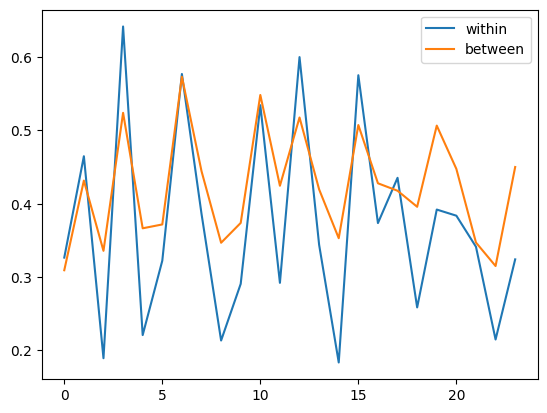

In [3]:
r1 = ds.reliability_within_subj(data_mdtb1,part_vec=info_mdtb1.half,cond_vec=info_mdtb1.cond_name)
r2 = ds.reliability_between_subj(data_mdtb1,cond_vec=info_mdtb1.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

In [15]:
data_mdtb2,info_mdtb2 = mydataset.get_data(atlas,'ses-s2','CondHalf')

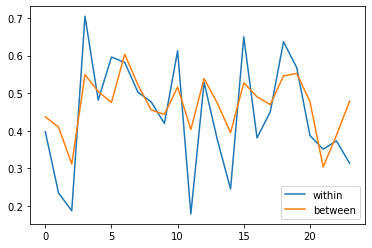

In [16]:
r1 = ds.reliability_within_subj(data_mdtb2,part_vec=info_mdtb2.half,cond_vec=info_mdtb2.cond_name)
r2 = ds.reliability_between_subj(data_mdtb2,cond_vec=info_mdtb2.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Pontine data set 

In [17]:
data_pt,info_pt,mydataset = ds.get_dataset(data_dir,'Pontine', atlas,['ses-01'],'TaskHalf')

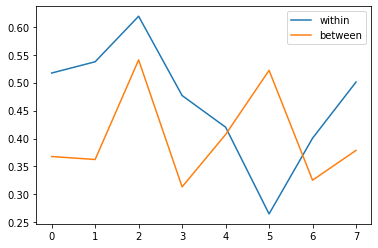

In [18]:
r1 = ds.reliability_within_subj(data_pt,part_vec=info_pt.half,
            cond_vec=info_pt.task_num)
r2 = ds.reliability_between_subj(data_pt,cond_vec=info_pt.task_num)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Nishimoto data set

In [20]:
nn_dataset = ds.DataSetNishi(data_dir + '/Nishimoto')
data_nn1,info_nn1 = nn_dataset.get_data(atlas,'ses-01',
                                        'CondHalf')
data_nn2,info_nn2 = nn_dataset.get_data(atlas,'ses-02',
                                        'CondHalf')


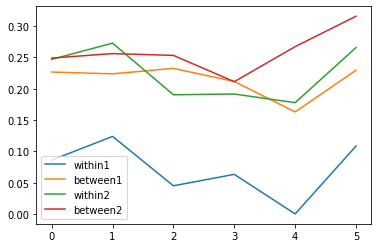

In [21]:
r1w = ds.reliability_within_subj(data_nn1,part_vec=info_nn1.half,cond_vec=info_nn1.reg_id)
r1b = ds.reliability_between_subj(data_nn1,cond_vec=info_nn1.reg_id)
r2w = ds.reliability_within_subj(data_nn2,part_vec=info_nn2.half,cond_vec=info_nn2.reg_id)
r2b = ds.reliability_between_subj(data_nn2,cond_vec=info_nn2.reg_id)
R = np.c_[r1w.mean(axis=1),r1b,r2w.mean(axis=1),r2b]
plt.plot(R)
plt.legend(['within1','between1','within2','between2'])

Interestingly, Data set 1 (training data) has very low within-person reliability. Why is this exactly?

### IBC data set
Do a session-wise test

In [7]:
dataset = ds.DataSetIBC(data_dir + '/IBC')
# Specify the fields you want to have / check 
T = dataset.get_participants()
num_sess = len(dataset.sessions)
RW = np.empty((T.shape[0],num_sess))
RB = np.empty((T.shape[0],num_sess))
Missing = np.empty((T.shape[0],num_sess))

for i,ses in enumerate(dataset.sessions):
    data,info = dataset.get_data('MNISymC3',ses,'CondHalf')
    m = np.isnan(data).sum(axis=1)
    Missing[:,i] = (m>0).sum(axis=1)
    rw = ds.reliability_within_subj(data,part_vec=info.half,cond_vec=info.reg_id,subtract_mean=False)
    RW[:,i] = rw.mean(axis=1)
    RB[:,i] = ds.reliability_between_subj(data,cond_vec=info.reg_id,subtract_mean=0)



/Users/callithrix/Python/Functional_Fusion/dataset.py:386: UserWarning: sub-11, ses-preference, CondHalf - missing data painting_constant-half2
  warnings.warn(f'{s}, {ses_id}, {type} - missing data {base[j]}')


(12, 14)


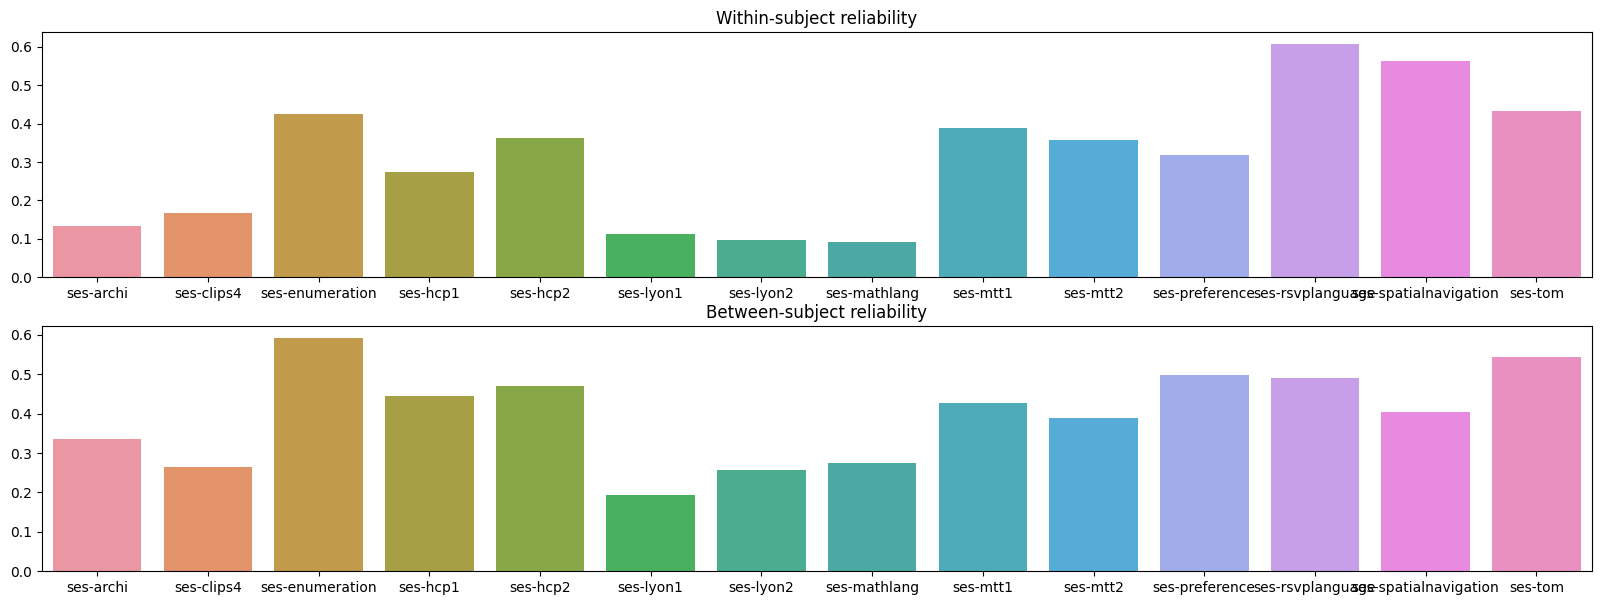

In [8]:
plt.figure(figsize=(20,7))
plt.subplot(2,1,1)
plt.title('Within-subject reliability')
sb.barplot(x=dataset.sessions,y=RW.mean(axis=0))
plt.subplot(2,1,2)
plt.title('Between-subject reliability')
sb.barplot(x=dataset.sessions,y=RB.mean(axis=0))
print(RB.shape)

<AxesSubplot: xlabel='Participant', ylabel='Between-subject reliability'>

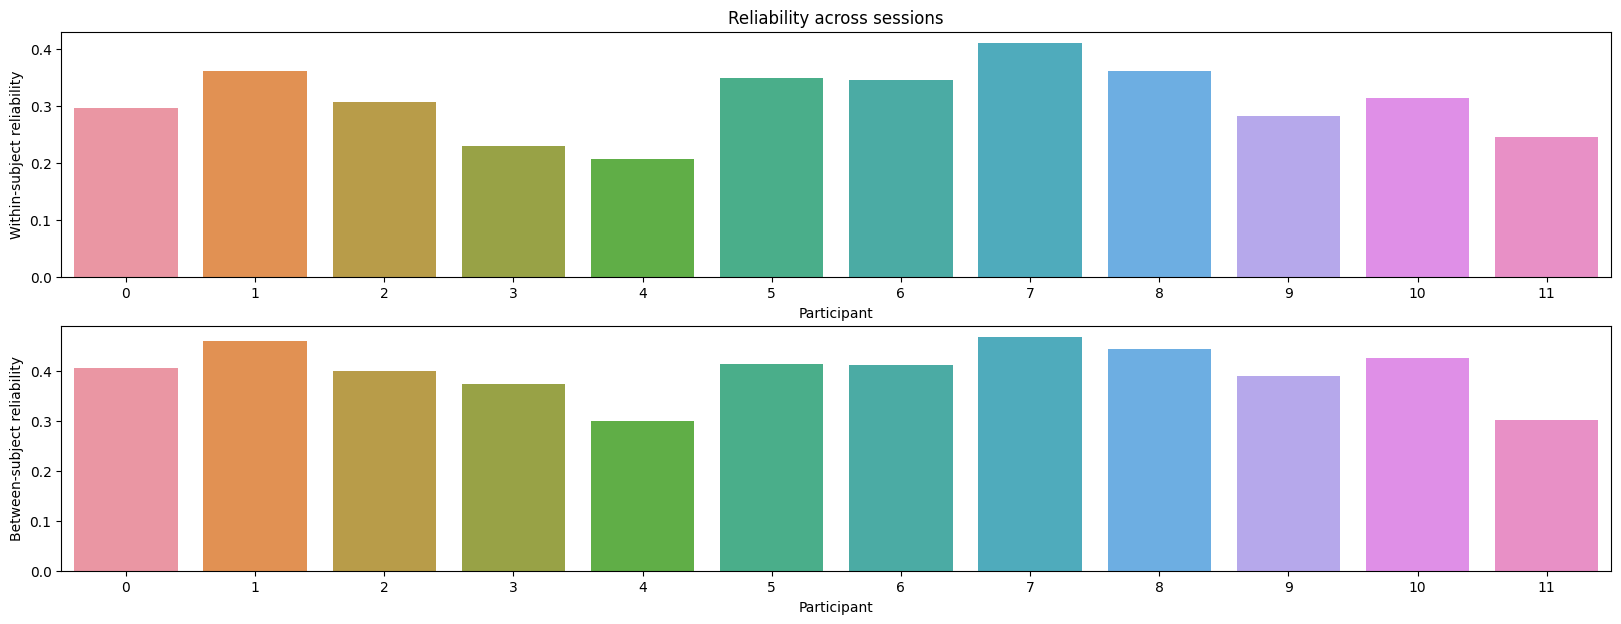

In [9]:
# Per Subject 
plt.figure(figsize=(20,7))
plt.subplot(2,1,1)
plt.title("Reliability across sessions")
plt.ylabel('Within-subject reliability')
plt.xlabel('Participant')
sb.barplot(x=np.arange(RW.shape[0]),y=RW.mean(axis=1))
plt.subplot(2,1,2)
plt.ylabel('Between-subject reliability')
plt.xlabel('Participant')
sb.barplot(x=np.arange(RB.shape[0]),y=RB.mean(axis=1))

2. Do a check of the entire dataset after concatinating all sessions

In [6]:
dataset = ds.DataSetIBC(data_dir + '/IBC')
# Specify the fields you want to have / check 
T = dataset.get_participants()
num_sess = len(dataset.sessions)

data,info,_ = ds.get_dataset(data_dir,'IBC',atlas='MNISymC3',type='CondHalf')


/Users/callithrix/Python/Functional_Fusion/dataset.py:386: UserWarning: sub-11, ses-preference, CondHalf - missing data painting_constant-half2
  warnings.warn(f'{s}, {ses_id}, {type} - missing data {base[j]}')


In [10]:
# Number of missing voxels per subject 
missing = np.isnan(data.sum(axis=1))
missing.sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<AxesSubplot: xlabel='sess'>

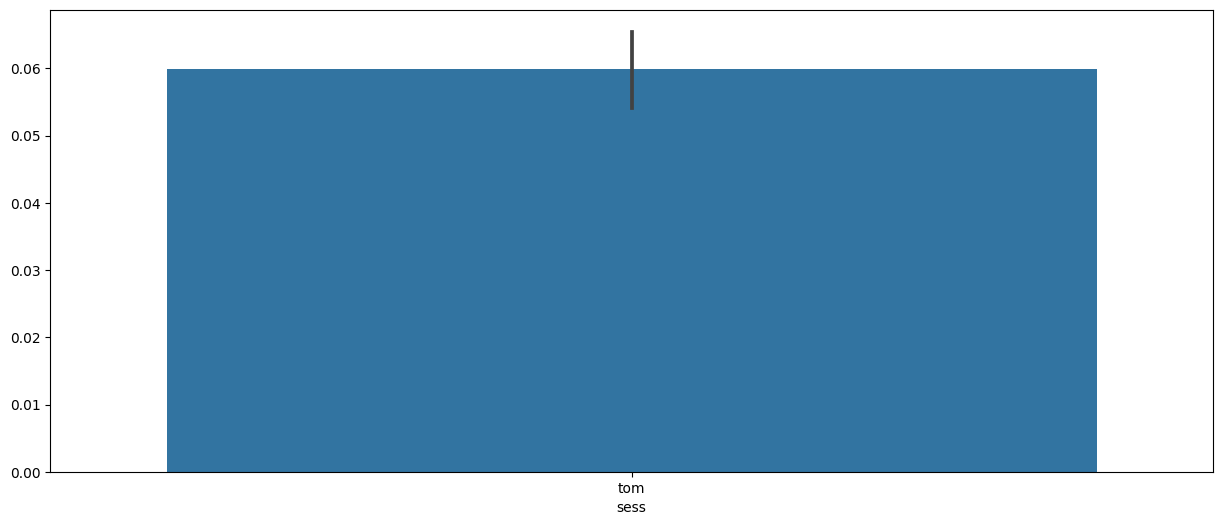

In [11]:
# variance of voxel patterns across sessions 
# This checks whether the activity estimates are approximately 
# equally scaled
# Variance over voxels, averaged across subject
STD = np.nanstd(data,axis=2).mean(axis=0)
plt.figure(figsize=(15,6))
sb.barplot(x=info.sess,y=STD)


## Check HCP dataset

### Connectivity Type: Icosahedron (type=IcoRun)

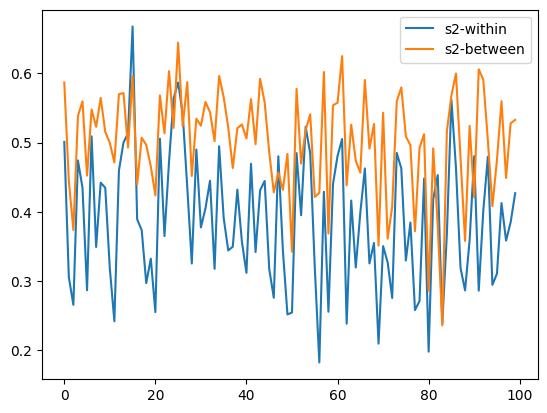

In [24]:

plt.plot(r1s2.mean(axis=1))
plt.plot(r2s2)
plt.legend(['s2-within','s2-between'])

### Connectivity Type: Network (type=NetRun) 
Estimated using 12 Networks (ICA dimensionality 25)

In [4]:
r1 = reliability_within_subj(
    data_hcpnets1, part_vec=info_hcpnets1.run, cond_vec=info_hcpnets1.region_name)
r2 = reliability_between_subj(
    data_hcpnets1, cond_vec=info_hcpnets1.region_name)


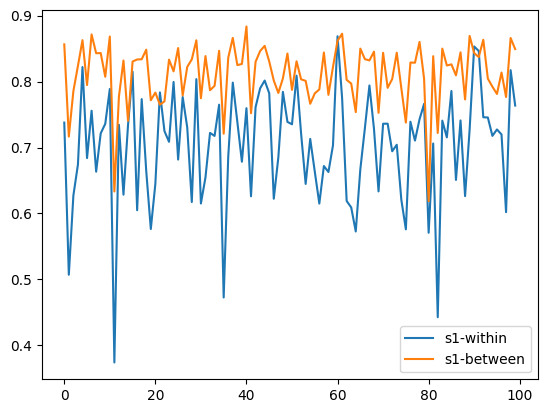

In [5]:
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['s1-within','s1-between'])

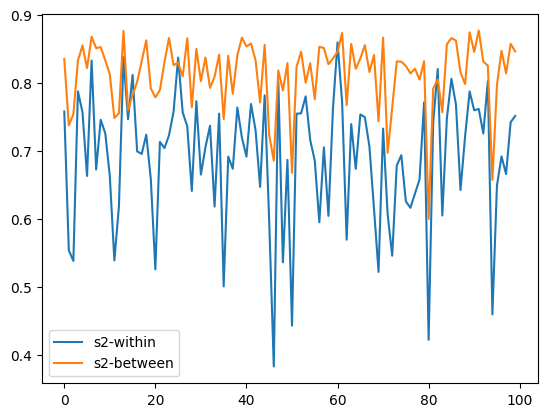

In [3]:
data_hcpnet2, info_hcpnet2 = hcpnets_dataset.get_data(
    'MNISymC3', ses_id='ses-s2', type='NetRun')
r1s2 = reliability_within_subj(
    data_hcpnet2, part_vec=info_hcpnet2.run, cond_vec=info_hcpnet2.region_name)
r2s2 = reliability_between_subj(data_hcpnet2, cond_vec=info_hcpnet2.region_name)
plt.plot(r1s2.mean(axis=1))
plt.plot(r2s2)
plt.legend(['s2-within','s2-between'])

### Connectivity Type: Network (type=NetAutoAll) 
Estimated using 69 Networks (ICA dimensionality automatic)

In [6]:
data_hcpnetsauto1, info_hcpnetsauto1, mydataset = ds.get_dataset(
    data_dir, 'HCP', atlas, ['ses-s1'], 'NetAutoAll')

In [18]:
part_vec = info_hcpnetsauto1.half
part_vec[:int(info_hcpnetsauto1.shape[0]/2)] = 2
r1s2 = ds.reliability_within_subj(
    data_hcpnetsauto1, part_vec=part_vec, cond_vec=info_hcpnetsauto1.region_name)
r2s2 = ds.reliability_between_subj(
    data_hcpnetsauto1, cond_vec=info_hcpnetsauto1.region_name)

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/callithrix/Python/Functional_Fusion/dataset.py:214: RuntimeWarning: Mean of empty slice
  X1 -= np.nanmean(X1, axis=0)
/Users/callithrix/Python/Functional_Fusion/dataset.py:215: RuntimeWarning: Mean of empty slice
  X2 -= np.nanmean(X2, axis=0)


In [16]:
data_hcpnetsauto1


array([[[            nan,             nan, -2.33266406e-02, ...,
          6.46987553e-02, -1.38271199e-01,  3.89231421e-02],
        [            nan,             nan,  1.50221060e-02, ...,
         -1.69301144e-02,  4.13013952e-02,  3.99017822e-02],
        [            nan,             nan, -1.31399899e-02, ...,
         -1.31017656e-02,  4.91513576e-03,  1.31686459e-04],
        ...,
        [            nan,             nan,  8.88832152e-02, ...,
         -1.97635098e-02,  1.01849496e-02, -4.23906429e-02],
        [            nan,             nan, -3.91417148e-04, ...,
         -2.88808897e-02, -1.00814285e-01, -6.83785335e-02],
        [            nan,             nan, -2.72187255e-02, ...,
          1.65980769e-02,  1.31520427e-02, -7.02861170e-03]],

       [[            nan,             nan, -1.70655643e-01, ...,
          4.86088260e-02,  9.47766046e-02,  2.09760326e-01],
        [            nan,             nan,  1.41062694e-02, ...,
         -2.65294333e-02, -9.42614974e

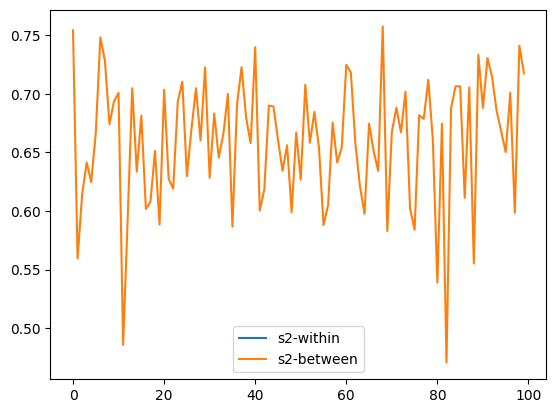

In [12]:
plt.plot(r1s2.mean(axis=1))
plt.plot(r2s2)
plt.legend(['s2-within','s2-between'])

## Check Demand dataset

In [12]:
mdtb_dataset = ds.DataSetDemand(data_dir + '/Demand')
data_de,info_de = mdtb_dataset.get_data(atlas,'ses-01','CondHalf')

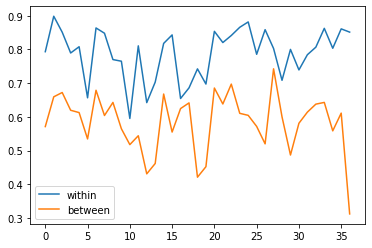

In [16]:
r1 = ds.reliability_within_subj(data_de,part_vec=info_de.half,cond_vec=info_de.cond_name,subtract_mean=False)
r2 = ds.reliability_between_subj(data_de,cond_vec=info_de.cond_name,subtract_mean=False)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

## WMFS dataset 

In [14]:

data,info,mydataset = ds.get_dataset(data_dir,'WMFS',atlas,'all','CondHalf')

/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:249: RuntimeWarning: Mean of empty slice
  X2 = util.nan_linear_model(Z,np.nanmean(X[i2,:,:],axis=0))


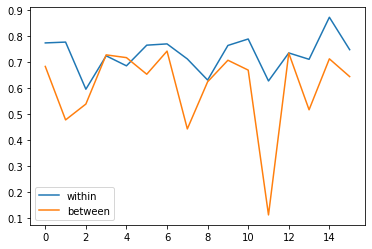

In [19]:
r1 = ds.reliability_within_subj(data,part_vec=info.half,cond_vec=info.cond_name,subtract_mean=False)
r2 = ds.reliability_between_subj(data,cond_vec=info.cond_name,subtract_mean=False)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

## Somatotopic dataset 

In [4]:
data,info,mydataset = ds.get_dataset(data_dir,'Somatotopic',atlas,'all','CondHalf')

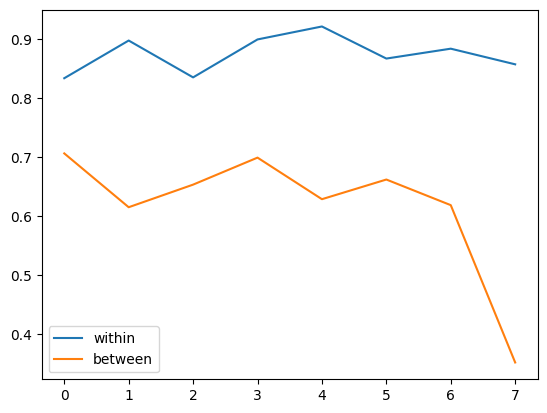

In [5]:
r1 = ds.reliability_within_subj(data,part_vec=info.half,cond_vec=info.cond_name,subtract_mean=False)
r2 = ds.reliability_between_subj(data,cond_vec=info.cond_name,subtract_mean=False)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])